In [1]:

# Import required packages
from os import path 
import time
# import numpy as np
import pandas as pd
import torch
from zuko.flows import CNF, NSF
from utils.settings import config as cfg
from utils.utils import *
from utils.model import *
from utils.robot import Robot
from spatialmath.base import r2q
from klampt.math import so3
import numpy as np
import quaternion

In [2]:
robot = Robot(verbose=False)
J_tr, P_tr, P_ts, F = load_all_data(robot, enable_normalize=False)
knn = get_knn(P_tr=P_tr)

knn load successfully from /home/luca/ikpflow/data/panda/train/knn-2500000-7-7-0-normFalse.pickle


In [ ]:
config = {
        'subnet_width': 1400,
        'subnet_num_layers': 3,
        'num_transforms': 9,
        'lr': 2.1e-4,
        'lr_weight_decay': 2.7e-2,
        'decay_step_size': 4e4,
        'gamma': 5e-2,
        'batch_size': 128,
        'num_epochs': 10,
    }

solver, optimizer, scheduler = get_flow_model(
        enable_load_model=cfg.use_pretrained,
        num_transforms=config["num_transforms"],
        subnet_width=config["subnet_width"],
        subnet_num_layers=config["subnet_num_layers"],
        lr=config["lr"],
        lr_weight_decay=config["lr_weight_decay"],
        decay_step_size=config["decay_step_size"],
        gamma=config["gamma"],
        device='cuda')

# flow = NSF(
#             features=cfg.n,
#             context=cfg.num_conditions,
#             transforms=config["num_transforms"],
#             randperm=True,
#             bins=10,
#             activation=cfg.activation,
#             hidden_features=[config["subnet_width"]] * config["subnet_num_layers"],
#         ).to('cuda')

# state = torch.load(cfg.path_solver)
# flow.load_state_dict(state_dict=state['solver'])

In [42]:
def null_space_motion(robot, q):
    jacob = robot.robot.jacob0(q)
    jacob_m = robot.robot.jacobm(q)
    null_motion = (1 - jacob.T@jacob)@jacob_m
    null_motion = null_motion / np.linalg.norm(null_motion)
    return null_motion

In [48]:
# NUM_STEPS = 250_0000 // 2
NUM_STEPS = 2000

position_distance = np.empty((NUM_STEPS))
null_distance = np.empty((NUM_STEPS))

from tqdm import trange
for step in trange(NUM_STEPS):
    i, j = np.random.randint(low=0, high=len(J_tr), size=2)
    p, q = J_tr[i], J_tr[j]
    p_n = null_space_motion(robot, p)
    q_n = null_space_motion(robot, q)
    
    position_distance[step] = np.linalg.norm(p - q)
    null_distance[step] = np.linalg.norm(p_n - q_n)

100%|██████████| 2000/2000 [00:00<00:00, 2206.87it/s]


In [47]:
i, j = np.random.randint(low=0, high=len(J_tr), size=2)
p, q = J_tr[i], J_tr[j]
p_n = null_space_motion(robot, p)
q_n = null_space_motion(robot, q)
p_n, q_n

(array([[-0.36178991],
        [-0.33319445],
        [-0.44395694],
        [-0.42265681],
        [-0.36399483],
        [-0.32215554],
        [-0.38219962]]),
 array([[ 0.52575653],
        [-0.15107655],
        [ 0.32279823],
        [ 0.67697068],
        [ 0.33674511],
        [ 0.12954674],
        [-0.08993508]]),
 0.9999999999999999,
 1.0)

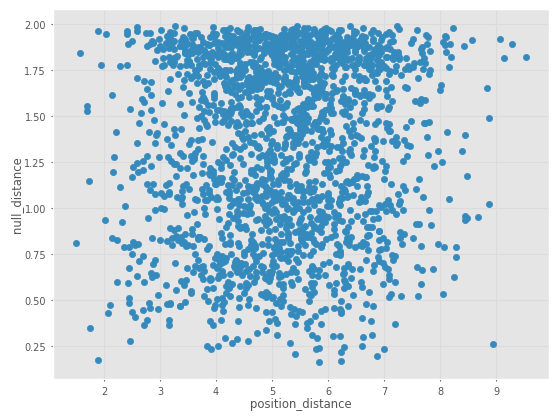

In [49]:
df = pd.DataFrame({'position_distance': position_distance,
                   'null_distance': null_distance})
plot = df.plot.scatter(x='position_distance', y='null_distance')

In [4]:
robot.robot.jacob0(q)


array([[-5.34405547e-01, -9.32011587e-02, -4.06480987e-01,
         3.50696702e-01, -6.00979127e-02,  9.63471482e-02,
         0.00000000e+00],
       [ 5.75799144e-01, -2.70886981e-02,  4.82005006e-01,
         4.55304714e-02,  4.22324581e-02,  1.34898739e-01,
         0.00000000e+00],
       [ 8.32667268e-17, -7.02069943e-01,  2.42481271e-01,
         4.84859462e-01,  5.94774399e-04,  1.56626042e-01,
         0.00000000e+00],
       [-2.49800181e-16, -2.79098072e-01,  6.60620327e-01,
         6.21958192e-01,  5.05344790e-01,  8.18155318e-01,
         1.96844048e-01],
       [-1.11022302e-16,  9.60262603e-01,  1.92007748e-01,
        -6.81372098e-01,  7.25694588e-01, -5.74940269e-01,
         2.93289847e-01],
       [ 1.00000000e+00,  0.00000000e+00,  7.25750513e-01,
        -3.85875720e-01, -4.66898285e-01, -8.09708382e-03,
        -9.35539142e-01]])

In [ ]:
robot.robot.jacob0(q).shape

In [5]:
robot.robot.jacobm(q)

array([[-9.84017629e-18],
       [ 4.61759671e-02],
       [-1.51573483e-02],
       [-4.83068014e-02],
       [ 1.10507072e-04],
       [-4.88088110e-02],
       [ 0.00000000e+00]])

In [ ]:
mu = torch.zeros(size=(cfg.n,))
NUM_DATA = 100
NUM_SAMPLES = 1000
df = test(robot=robot, P_ts=P_ts[:NUM_DATA], F=F, solver=solver, knn=knn, K=NUM_SAMPLES, print_report=True)

In [ ]:
iflow = get_iflow_model(solver, init_sample=mu, shrink_ratio=0.11)
test(robot=robot, P_ts=P_ts[:NUM_DATA], F=F, solver=iflow, knn=knn, K=NUM_SAMPLES, print_report=True)

In [ ]:
# public final void set(Matrix4f m1) {
# 	w = Math.sqrt(1.0 + m1.m00 + m1.m11 + m1.m22) / 2.0;
# 	double w4 = (4.0 * w);
# 	x = (m1.m21 - m1.m12) / w4 ;
# 	y = (m1.m02 - m1.m20) / w4 ;
# 	z = (m1.m10 - m1.m01) / w4 ;
# }

def rot2qua(R):
    w = np.sqrt(1.0 + R[0, 0] + R[1, 1] + R[2, 2]) / 2.0
    w4 = 4.0 * w
    
    x = (R[2, 1] - R[1, 2]) / w4
    y = (R[0, 2] - R[2, 0]) / w4
    z = (R[1, 0] - R[0, 1]) / w4
    
    return (w, x, y, z)

In [ ]:
rot2qua(T.R)

In [ ]:
i = 6
neigh_idx = knn.kneighbors([P_ts_norm[i, :3]], n_neighbors=2, return_distance=False)
neigh_idx = neigh_idx.flatten()
neigh_idx, P_tr_norm[neigh_idx], P_ts_norm[i]

In [ ]:
i = 6
neigh_idx = knn.kneighbors([P_ts[i, :3]], n_neighbors=2, return_distance=False)
neigh_idx = neigh_idx.flatten()
neigh_idx, P_tr[neigh_idx], P_ts[i]

In [ ]:
neigh_idx = [2078302, 1221060]
neigh_idx, P_tr[neigh_idx], P_ts[i]

In [ ]:
i = 6
neigh_idx = knn.kneighbors([P_ts[i, :3]], n_neighbors=2, return_distance=False)
neigh_idx = neigh_idx.flatten()
neigh_idx, P_tr[neigh_idx], P_ts[i]

In [ ]:
i = 0
robot.position_orientation_errors_Arr_Inputs([J_tr_norm[i]], P_tr_norm[i])

In [ ]:
from pprint import pprint
def show_stat(arr):
    min = arr.min(axis=0)
    mean = arr.mean(axis=0)
    max = arr.max(axis=0)
    pprint((min, mean, max))

In [ ]:
show_stat(F)

In [ ]:
robot.joint_min, robot.joint_max

In [ ]:
J_norm = normalize(J_tr)
J_denorm = denormalize(J_norm, robot.joint_min, robot.joint_max)

In [ ]:
J_tr.min(axis=0), J_tr.max(axis=0), J_tr.mean(axis=0)

In [ ]:
J_denorm.min(axis=0), J_denorm.max(axis=0), J_denorm.mean(axis=0)

In [ ]:
J_norm.max(axis=0)

In [ ]:
df = pd.DataFrame(P_tr)
df.min().to_numpy(), df.max().to_numpy()

In [ ]:
df = pd.DataFrame(J_tr)
df.min(), df.max()

In [ ]:
df.min().to_numpy(), df.max().to_numpy()

In [ ]:
train_loader = get_train_loader(J=J_tr,
                                    P=P_tr,
                                    F=F,
                                    device='cuda',
                                    batch_size=128)

# Build Generative model, NSF
# Neural spline flow (NSF) with 3 sample features and 5 context features
solver, optimizer, scheduler = get_flow_model(
    load_model=cfg.use_pretrained,
    num_transforms=7,
    subnet_width=1024,
    subnet_num_layers=3,
    lr=4.8e-4,
    lr_weight_decay=5e-3,
    decay_step_size=4e4,
    gamma=0.5,
    device='cuda')

In [ ]:
rand = np.random.randint(low=0, high=len(P_ts), size=cfg.num_eval_size)
_, position_errors, _, _ = test(
    robot=robot,
    P_ts=P_ts[rand],
    F=F,
    solver=solver,
    knn=knn,
    K=cfg.K,
    print_report=False,
)

In [ ]:
com_pos = np.zeros((100, 7))

In [ ]:
com_pos[:, :3]

In [ ]:
position_errors

In [ ]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_cifar(config):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    data_dir = os.path.abspath("./data")
    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

In [ ]:
def _test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
def test_best_model(best_result):
    best_trained_model = Net(best_result.config["l1"], best_result.config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best trial test set accuracy: {}".format(correct / total))

In [ ]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
}

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=2, max_num_epochs=2, gpus_per_trial=0)

In [ ]:
print(f"#trials={len(result.trials)}")
print(f"time={time.time()-start_time}")
best_trial = result.get_best_trial("loss", "min", "all")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.metric_analysis["loss"]["min"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.metric_analysis["accuracy"]["max"]))

best_trained_model = Net(2**best_trial.config["l1"],
                         2**best_trial.config["l2"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

checkpoint_value = getattr(best_trial.checkpoint, "dir_or_data", None) or best_trial.checkpoint.value
checkpoint_path = os.path.join(checkpoint_value, "checkpoint")

model_state, optimizer_state = torch.load(checkpoint_path)
best_trained_model.load_state_dict(model_state)

test_acc = _test_accuracy(best_trained_model, device)
print("Best trial test set accuracy: {}".format(test_acc))